# Consignador NN - Regresion Logistica

## Contenido
1. [Importar librerias](#Importar-librerias)
2. [Cargar datos](#Cargar-datos)
3. [Preparar datos](#Preparar-datos)
4. [Modelo](#Modelo)
5. [Entrenamiento](#Entrenamiento) (#TODO: agregar grafico de perdida y guardar mejor modelo en cada epoca)
6. [Validacion](#Validacion)
7. [Prediccion](#Prediccion)
8. [Guardar modelo](#Guardar-modelo)


## Importar librerias

In [18]:
# Importar librerias
import utilities as ut
import pandas as pd
import numpy as np
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.metrics import AUC, Precision, Recall
from matplotlib import pyplot as plt

## Cargar datos

In [19]:
data = pd.read_pickle(ut.INCIDENTES_CAMARAS_FILENAME)
# convertir el id_camara a int
data['id_camara'] = data['id_camara'].astype(int)
data

,folio,incidente_c4,fecha_creacion,sector_inicio,delegacion_inicio,colonia,latitud,longitud,id_camara
0,C2C/20220112/00030,Administrativas-Drogados,2022-01-12 08:49:38,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
1,C5/20220118/00090,Robo-Transeúnte,2022-01-18 00:49:47,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435149,-99.147325,1
2,C2C/20230108/00178,Disturbio-Riña,2023-01-08 20:47:51,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
3,C5/20230122/01336,Administrativas-Ebrios,2023-01-22 05:10:07,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435149,-99.147325,1
4,C2C/20220202/00008,Administrativas-Ebrios,2022-02-02 01:19:04,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
...,...,...,...,...,...,...,...,...,...
31972,C2N/20210727/00036,Robo-Transeúnte,2021-07-27 10:06:22,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435700,-99.116500,17290
31973,C5/20220814/00067,Disturbio-Escándalo,2022-08-14 00:07:55,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435692,-99.116920,17290
31974,C2N/20210906/00030,Robo-Establecimiento con Violencia,2021-09-06 11:43:53,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435486,-99.115698,17290
31975,C2N/20220902/00049,Robo-Transeúnte,2022-09-02 10:11:05,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435700,-99.116500,17290


#### Cargar datos de puntos de interes

In [20]:
DIR_PATH = '\\\\C4wadpninv004\\ANALISIS II-DGGE\\02. SME\\GUSTAVO\\'
# DIR_PATH = '..\\data\\'
FILE_PATH = DIR_PATH + 'B200m_CONSIGNADAS.csv'
FILE_PATH = DIR_PATH + 'B200m_CONSIGNADAS-v3.csv'
data_interest_points = pd.read_csv(FILE_PATH, sep=',', encoding='latin-1')
# Renombrar la columna 'Etiquetas' a 'id_camara'
data_interest_points.rename(columns={'id': 'id_camara'}, inplace=True)
# Ordenar los datos por la columna 'id_camara'
data_interest_points.sort_values(by=['id_camara'], inplace=True)
# Resetear los índices
data_interest_points.reset_index(drop=True, inplace=True)

data_interest_points

,id_camara,latitud,longitud,sector,tipo,C01-BANCOS,C05-CENTRALES CAMIONERAS,C06-CENTROS COMERCIALES,C09-CUARTELES DE LA POLICÍA AUXILIAR,C10-CUARTELES PBI,...,C62-OXXO,C67-CENTROS PILARES,C72-ACCESOS METRO,C73-ATRACTIVOS TURISTICOS,C75-FONOTECAS,C76-FOTOTECA,C77-GALERIAS,C78-ZONAS ARQUEOLOGICAS,C81-ESTACIONES DE CABLEBUS,C82-ALCALDIAS
0,1,19.435283,-99.147152,ALAMEDA,9m,25,0,1,0,0,...,4,0,1,3,0,0,2,0,0,0
1,2,19.435098,-99.145820,ALAMEDA,9m,27,0,1,0,0,...,1,0,0,4,0,0,1,0,0,0
2,3,19.434573,-99.143858,ALAMEDA,9m,15,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,19.434374,-99.142704,ALAMEDA,9m,16,0,1,0,0,...,2,0,1,2,0,0,1,0,0,0
4,5,19.434242,-99.141880,ALAMEDA,9m,13,0,1,0,0,...,2,0,2,3,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,12318,19.435075,-99.119716,CONGRESO,9m,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
442,12578,19.439129,-99.139482,CENTRO,9m,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
443,13795,19.436069,-99.121176,CONGRESO,9m,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
444,16948,19.434749,-99.144808,ALAMEDA,9m,21,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0


#### Agrupar los puntos de interes

In [21]:
IP_groups = [['C09-CUARTELES DE LA POLICÍA AUXILIAR','C10-CUARTELES PBI','C11-CUARTELES PGJ','C16-JUZGADOS CIVILES Y PENALES','C20-MINISTERIOR PUBLICOS','C21-MODULOS SSP',],    # P01 - Seguridad

['C05-CENTRALES CAMIONERAS','C19-METROBUS','C31-TREN LIGERO','C42-TROLEBUS','C43-TURIBUS','C72-ACCESOS METRO','C81-ESTACIONES DE CABLEBUS',],                                        # P02 - Transporte

['C06-CENTROS COMERCIALES','C38-MERCADOS PUBLICOS','C49-TIENDAS DEPARTAMENTALES','C53-CINES','C62-OXXO',],#'C46-ESTABLECIMIENTOS MERCANTILES',],                                    # P03 - Comercio

['C22-MONUMENTOS HISTORICOS', 'C57-EVENTOS MASIVOS', 'C73-ATRACTIVOS TURISTICOS', 'C78-ZONAS ARQUEOLOGICAS',],                                                                        # P04 - Turismo

['C58-CASAS Y CENTROS DE CULTURA','C59-MUSEOS Y TEATROS','C75-FONOTECAS','C76-FOTOTECA','C77-GALERIAS', 'C26-PLAZAS Y PARQUES',],                                                    # P05 - Cultura

['C23-NOTARIAS','C24-OFICINAS DE GOBIERNO','C27-RECLUSORIOS','C30-TESORERIAS','C82-ALCALDIAS', 'C01-BANCOS'],                                                                        # P06 - Gobierno

['C15-HOSPITALES','C45-CENTROS DE SALUD Y CLINICAS',],                                                                                                                                # P07 - Hospitales

['C44-GUARDERIAS', 'C67-CENTROS PILARES', 'C13-EDUCACION',],#'C13-CAM', 'C13-CPARA EL TRABAJO', 'C13_PREESC', 'C13_PRIM', 'C13_SEC', 'C13_BACH', 'C13_SUP',],                                            # P08 - Escuelas

['C33-IGLESIAS Y TEMPLOS',],                                                                                                                                                        # P09 - Iglesias

['C51-EDIFICIOS',],]                                                                                                                                    # P10 - Edificios

# Cada nueva columna es la suma de las columnas que se encuentran en la lista de agrupaciones con nombre GRUPO-k
for i in range(len(IP_groups)):
    data_interest_points['P.Interes-'+str(i+1)] = data_interest_points[IP_groups[i]].sum(axis=1)
    # # Eliminamos las columnas que ya no se van a utilizar
    data_interest_points = data_interest_points.drop(IP_groups[i], axis=1)
data_interest_points = data_interest_points.drop(["C46-ESTABLECIMIENTOS MERCANTILES"], axis=1)

# Estandarizamos los datos
scaler = StandardScaler(with_mean=False, with_std=False)
data_interest_points[data_interest_points.filter(regex='^P.Interes-\d+').columns] = scaler.fit_transform(data_interest_points[data_interest_points.filter(regex='^P.Interes-\d+').columns])
# data_interest_points[data_interest_points.filter(regex='^P.Interes-\d+').columns] = data_interest_points[data_interest_points.filter(regex='^P.Interes-\d+').columns].copy()
data_interest_points

,id_camara,latitud,longitud,sector,tipo,P.Interes-1,P.Interes-2,P.Interes-3,P.Interes-4,P.Interes-5,P.Interes-6,P.Interes-7,P.Interes-8,P.Interes-9,P.Interes-10
0,1,19.435283,-99.147152,ALAMEDA,9m,1.0,4.0,9.0,14.0,7.0,25.0,0.0,3.0,0.0,0.0
1,2,19.435098,-99.145820,ALAMEDA,9m,1.0,2.0,5.0,12.0,6.0,27.0,0.0,3.0,0.0,0.0
2,3,19.434573,-99.143858,ALAMEDA,9m,1.0,1.0,4.0,11.0,4.0,16.0,0.0,1.0,1.0,0.0
3,4,19.434374,-99.142704,ALAMEDA,9m,0.0,2.0,7.0,8.0,4.0,17.0,0.0,1.0,1.0,0.0
4,5,19.434242,-99.141880,ALAMEDA,9m,0.0,4.0,8.0,8.0,7.0,14.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,12318,19.435075,-99.119716,CONGRESO,9m,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
442,12578,19.439129,-99.139482,CENTRO,9m,0.0,6.0,1.0,1.0,4.0,0.0,1.0,3.0,1.0,0.0
443,13795,19.436069,-99.121176,CONGRESO,9m,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
444,16948,19.434749,-99.144808,ALAMEDA,9m,1.0,1.0,3.0,13.0,4.0,22.0,0.0,1.0,1.0,0.0


In [22]:
data['date'] = data['fecha_creacion'].dt.strftime('%Y-%m-%d').astype('datetime64[ns]')
camaras_fechas_frecuencias = data.groupby(['id_camara', 'date']).size().reset_index(name='n_incidentes')

# Convertir la columna de fecha a datetime si aún no lo es
camaras_fechas_frecuencias['date'] = pd.to_datetime(camaras_fechas_frecuencias['date'])

# Crear un DataFrame con todas las fechas posibles

fechas = pd.date_range(start='2021-01-01', end=camaras_fechas_frecuencias['date'].max().date().isoformat())

# Obtener los id únicos de camara
camaras = camaras_fechas_frecuencias['id_camara'].unique()

# Crear un DataFrame con todas las combinaciones posibles de id_camara y fechas
df_total = pd.DataFrame(index=pd.MultiIndex.from_product([camaras, fechas], names=['id_camara', 'date'])).reset_index()

# Unir el DataFrame total con el DataFrame original
data_final = pd.merge(df_total, camaras_fechas_frecuencias, how='left', on=['id_camara', 'date'])

# Llenar los valores nulos con 0
data_final['n_incidentes'] = data_final['n_incidentes'].replace(np.nan, 0)

# Ahora desagregamos la fecha
data_final['anio'] = data_final['date'].dt.year
data_final['mes'] = data_final['date'].dt.month
data_final['dia_semana'] = data_final['date'].dt.dayofweek+1
data_final['dia'] = data_final['date'].dt.day
# data_final['hora'] = data_final['date'].dt.hour

# data_final.drop(['date'], axis=1, inplace=True)



data_final

,id_camara,date,n_incidentes,anio,mes,dia_semana,dia
0,1,2021-01-01,0.0,2021,1,5,1
1,1,2021-01-02,0.0,2021,1,6,2
2,1,2021-01-03,0.0,2021,1,7,3
3,1,2021-01-04,0.0,2021,1,1,4
4,1,2021-01-05,0.0,2021,1,2,5
...,...,...,...,...,...,...,...
365269,17290,2023-03-26,0.0,2023,3,7,26
365270,17290,2023-03-27,0.0,2023,3,1,27
365271,17290,2023-03-28,0.0,2023,3,2,28
365272,17290,2023-03-29,0.0,2023,3,3,29


#### Asignar los puntos de interes a la cada registro de la base de datos de 'data'

In [23]:
# Recorrer los registros del df data y agregar las columnas de P.Interes de acuerdo a la columna id_camara
interest_points_columns = data_interest_points.filter(regex='^P.Interes-\d+').columns
data_final[data_interest_points.filter(regex='^P.Interes-\d+').columns] = 0
for i in range(len(data_final)):
    print(f"Procesando registro {i+1} de {len(data_final)}", end='\r')
    id_camara = data_final['id_camara'].iloc[i]
    # Buscar el id_camara en el df data_interest_points
    index = data_interest_points[data_interest_points['id_camara'] == id_camara].index
    if len(index) > 0:
        data_final.loc[i, interest_points_columns] = data_interest_points.loc[index[0], interest_points_columns]#**2

# data_final['n_incidentes'] = data_final['n_incidentes'].apply(lambda x: 0 if x == 0 else 1)

data = data_final.copy()
data

,id_camara,date,n_incidentes,anio,mes,dia_semana,dia,P.Interes-1,P.Interes-2,P.Interes-3,P.Interes-4,P.Interes-5,P.Interes-6,P.Interes-7,P.Interes-8,P.Interes-9,P.Interes-10
0,1,2021-01-01,0.0,2021,1,5,1,1,4,9,14,7,25,0,3,0,0
1,1,2021-01-02,0.0,2021,1,6,2,1,4,9,14,7,25,0,3,0,0
2,1,2021-01-03,0.0,2021,1,7,3,1,4,9,14,7,25,0,3,0,0
3,1,2021-01-04,0.0,2021,1,1,4,1,4,9,14,7,25,0,3,0,0
4,1,2021-01-05,0.0,2021,1,2,5,1,4,9,14,7,25,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365269,17290,2023-03-26,0.0,2023,3,7,26,0,1,0,0,1,0,0,0,0,0
365270,17290,2023-03-27,0.0,2023,3,1,27,0,1,0,0,1,0,0,0,0,0
365271,17290,2023-03-28,0.0,2023,3,2,28,0,1,0,0,1,0,0,0,0,0
365272,17290,2023-03-29,0.0,2023,3,3,29,0,1,0,0,1,0,0,0,0,0


In [24]:

date_split = '2023-01-01'
# date_split = '2022-10-01'

#Split data into train and test, train will be until 2022 and test will be rest of the data
train = data[data['date'] < date_split]
test = data[data['date'] >= date_split]

#Split train and test into X and y
X_train = train.drop(['id_camara', 'n_incidentes', 'date'], axis=1)
y_train = train['n_incidentes']
X_test = test.drop(['id_camara', 'n_incidentes', 'date'], axis=1)
y_test = test['n_incidentes']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# Imprimir el porcentaje de train y test respecto al total
print(f"Porcentaje de train: {round(len(train)/len(data)*100, 2)}%")
print(f"Porcentaje de test: {round(len(test)/len(data)*100, 2)}%")

(325580, 14) (325580,) (39694, 14) (39694,)
Porcentaje de train: 89.13%
Porcentaje de test: 10.87%


### Oversampling

In [25]:
# Oversampling para las clases minoritarias
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Resumen de la distribución de clases
from collections import Counter
counter = Counter(y_train)
print(counter)


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

### Modelo de Red Neuronal - Regresion Logistica

##### Deteccion del ultimo modelo ya existente

In [ ]:
MODELS_PATH = '../models/'
import os

# Find last model id from filename structure: model-{id}-{epoch:03d}-{accuracy:.3f}.h5
def find_last_model_id():
    last_model_id = 0
    for file in os.listdir(MODELS_PATH):
        if file.startswith('model-'):
            model_id = int(file.split('-')[1])
            if model_id > last_model_id:
                last_model_id = model_id
    return last_model_id
print(find_last_model_id())


3


##### Creacion del modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                480       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
15059/15059 [==============================] - 28s 2ms/step - loss: 0.3750 - accuracy: 0.6250 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
15059/15059 [========

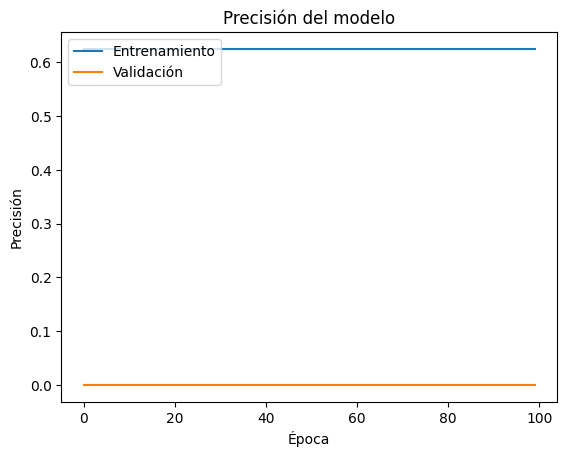

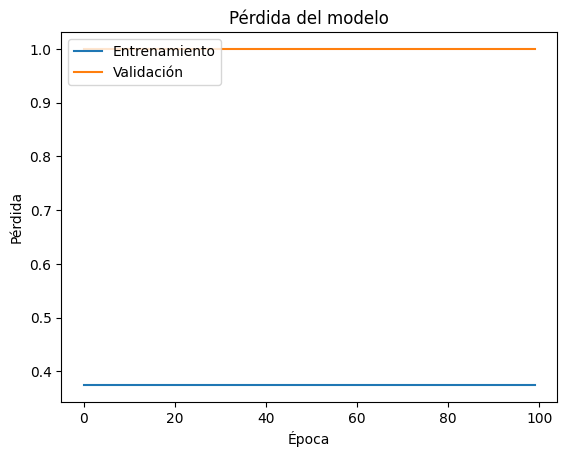

[[37268     0]
 [ 2426     0]]


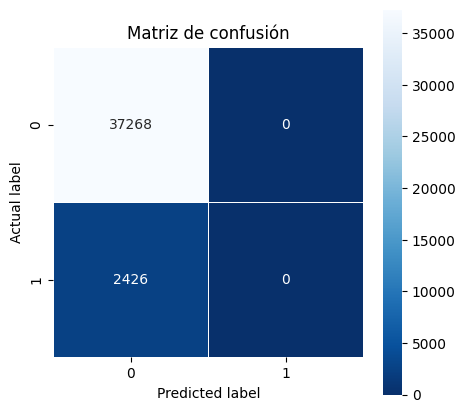

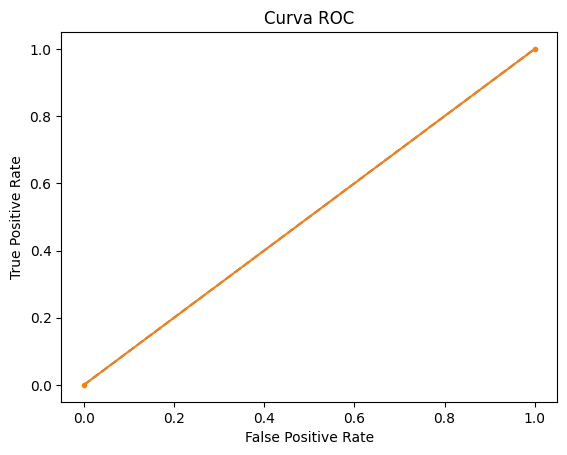

36

In [ ]:
# Creacion del modelo con grafica de perdida y accuracy
# Pasos:
# 1. Definir el modelo
# 2. Entrenar el modelo
# 3. Evaluar el modelo
# 4. Guardar el modelo
# 5. Cargar el modelo
# 6. Hacer predicciones con el modelo

# Solo toma como el total, los que son 1 y de esos verifica cuantos y_pred son 1
def c5_score(y_true, y_pred):
	import tensorflow as tf
	y_true = tf.cast(y_true, tf.float32) # cast means convert
	y_pred = tf.cast(tf.round(y_pred), tf.float32) # round means round to nearest integer
	# probando el valor que debera regresar
	y_pred[y_true != 0] = 1
	return tf.keras.metrics.binary_accuracy(y_true, y_pred)

# 1 Definir el modelo
def create_model(input_dim, output_dim, hidden_layers, neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
    for i in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adagrad', metrics=['accuracy', c5_score])
    return model

# 2 Entrenar el modelo
def train_model(model, X_train, y_train, epochs, batch_size, validation_split, model_id):
    # Crear el callback para guardar el modelo
    checkpoint = ModelCheckpoint(MODELS_PATH+'model-'+model_id+'-{accuracy:.4f}-{epoch:03d}.h5', verbose=0, monitor='accuracy', save_best_only=True, mode='auto')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[checkpoint])
    return history

# 3 Evaluar el modelo
def evaluate_model(model, X_test, y_test):
    _, accuracy = model.evaluate(X_test, y_test) # loss, accuracy
    return accuracy

# 4 Guardar el mejor modelo (el que tenga el mejor accuracy)
def save_model(model, model_id, accuracy, epoch):
    model.save(f'{MODELS_PATH}model-{model_id}-{epoch:03d}-{accuracy:.3f}.h5')
    
# 5 Cargar el modelo
def load_model(model_path):
    model = load_model(model_path, custom_objects={'c5_score': c5_score})
    return model

# 6 Hacer predicciones con el modelo
def predict(model, X):
    predictions = model.predict(X)
    return predictions

# 7 Graficar la perdida y el accuracy
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Precisión del modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Pérdida del modelo')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()
        
# 8 Graficar la matriz de confusión
def plot_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de confusión')
    plt.show()
        
# 9 Graficar la curva ROC (Receiver Operating Characteristic), es decir, la curva de la sensibilidad (recall) vs la especificidad
def plot_roc_curve(y_test, y_pred):
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title('Curva ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


# 1 Definir el modelo
model = create_model(input_dim=X_train.shape[1], output_dim=1, hidden_layers=2, neurons=32)
model.summary()
print("")
model_id = find_last_model_id() + 1

# 2 Entrenar el modelo
history = train_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, model_id=str(model_id))

# 3 Evaluar el modelo
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')

# 4 Guardar el mejor modelo (el que tenga el mejor accuracy)
save_model(model, model_id, accuracy, len(history.history['accuracy']))

# 5 Cargar el modelo
# model = load_model(f'{MODELS_PATH}model-{model_id}-{len(history.history["accuracy"]):03d}-{accuracy:.3f}.h5')

# 6 Hacer predicciones con el modelo
y_pred = predict(model, X_test)
y_pred = np.round(y_pred).astype(int).reshape(1, -1)[0]
print(y_pred)

# 7 Graficar la perdida y el accuracy
plot_history(history)

# 8 Graficar la matriz de confusión
plot_confusion_matrix(y_test, y_pred)

# 9 Graficar la curva ROC (Receiver Operating Characteristic), es decir, la curva de la sensibilidad (recall) vs la especificidad
plot_roc_curve(y_test, y_pred)

In [ ]:
# # Crear red neuronal de regresión logística
# # Definir el modelo
# model = Sequential()

# # Añadir la capa de entrada y una capa oculta de 64 neuronas
# model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
# # Añadir la capa de entrada y una capa oculta de 32 neuronas
# model.add(Dense(32, activation='relu'))
# # Añadir la capa de entrada y una capa oculta de 32 neuronas
# model.add(Dense(32, activation='relu'))
# # Añadir otra capa oculta
# model.add(Dense(16, activation='relu'))
# # Añadir la capa de salida binaria, 0 o 1, no numeros decimales
# model.add(Dense(1, activation='sigmoid'))

# from keras.optimizers import Adam, Adagrad, SGD

# # Para condicion de paro en convergencia realizar el siguiente paso
# # En la linea 

# # Compilar el modelo
# model.compile(optimizer=Adagrad(learning_rate=0.01),
#               loss='binary_crossentropy', 
#               metrics=['accuracy', AUC(name='auc')])


# # Crear el callback para guardar el modelo
# ID_NEW_MODEL = find_last_model_id() + 1
# checkpoint = ModelCheckpoint(MODELS_PATH+'model-'+str(ID_NEW_MODEL)+'-{accuracy:.4f}-{epoch:03d}.h5', verbose=0, monitor='accuracy', save_best_only=True, mode='auto')
# # Entrenar el modelo
# # model.fit(data.drop(['id_camara','date','n_incidentes'], axis=1), data['n_incidentes'], epochs=100, callbacks=[checkpoint], validation_split=0.2)
# model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint], validation_split=0.2, use_multiprocessing=True, workers=4)

# # Guardar el modelo
# model.save(f'{MODELS_PATH}model-{ID_NEW_MODEL}.h5')

In [ ]:

# Cargar el modelo (Recuerda importar la librería: from keras.models import load_model)
# model = load_model(f'{MODELS_PATH}model-{ID_NEW_MODEL}.h5')
model = load_model(f'{MODELS_PATH}model-2-0.6255-091.h5')
model.evaluate(X_test, y_test) 

RecursionError: maximum recursion depth exceeded

In [ ]:
# Predecir
probs = model.predict(X_test)
probs = probs.reshape((probs.shape[0],))
labels = (probs >= 0.5).astype(int)
probs, labels
# np.unique(probs, return_counts=True)
# predictions = np.round(predictions)
# predictions = predictions.astype(int)
# np.unique(labels, return_counts=True)

1241/1241 [==============================] - 1s 1ms/step


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
# Calcular el accuracy
print("Accuracy:",metrics.classification_report(y_test, labels))

# Calcular la matriz de confusión
print(metrics.confusion_matrix(y_test, labels, labels=y_test.unique()))

Accuracy:               precision    recall  f1-score   support

           0       0.94      1.00      0.97     37268
           1       0.00      0.00      0.00      2426

    accuracy                           0.94     39694
   macro avg       0.47      0.50      0.48     39694
weighted avg       0.88      0.94      0.91     39694

[[37268     0]
 [ 2426     0]]


c:\Users\jhernandeza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jhernandeza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jhernandeza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

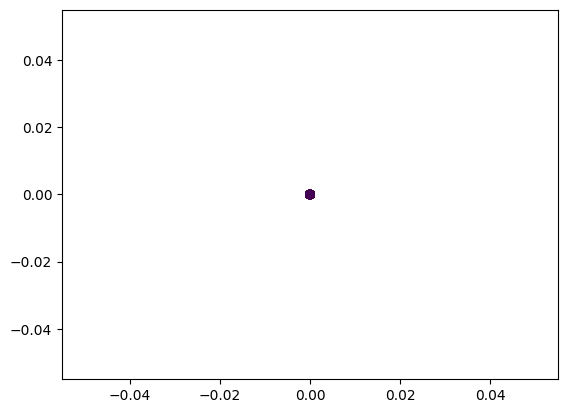

In [ ]:
# Realizar dos graficas, una con los datos de labels y otra con los datos de y_test
# El eje x es probs (probabilidades) y el eje y es el redondeo de las probabilidades, el color sera si son verdaderamente 0 o 1
import matplotlib.pyplot as plt
plt.scatter(probs, labels, c=y_test)
plt.show()
